In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Extended structured model

## Load and format data

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("/Users/arnaud/cellule/data/bnpp2/BNPPjoined.csv")

/Users/arnaud/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (54,55,56,58,65) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We filter the data loaded above to keep only electronic trades processed by EBNP. Furthermore, we focus on RFQs with `Done`, `TradedAway` or `NotTraded` status.

In [4]:
idx_elec = df["VoiceElec"] == "ELEC"
idx_venue = df["Venue"] == "EBNP"
idx_hasmid = ~np.isnan(df["RFQCompositeMid"])
idx_buy = df["BuySell"].values == "Buy"
df = df[idx_buy & idx_hasmid & idx_venue & idx_elec]

idx_done = df["TradeStatus"].values == "Done"
idx_traded_away = df["TradeStatus"].values == "TradedAway"
idx_not_traded = df["TradeStatus"].values == "NotTraded"

In [5]:
dd = df[idx_done + idx_traded_away + idx_not_traded]

In [6]:
ratio = abs(dd["BNPPStreamedMid"] - dd["BNPPStreamedQuote"])
data = pd.DataFrame({
        'Y': (dd["BNPPAnsweredQuote"] - dd["RFQCompositeMid"]) / ratio,
        'C1': (dd["CoverPrice"] - dd["RFQCompositeMid"]) / ratio,
        'C2': (dd["CoverPrice2"] - dd["RFQCompositeMid"]) / ratio,
        'C3': (dd["CoverPrice3"] - dd["RFQCompositeMid"]) / ratio,
        'C4': (dd["CoverPrice4"] - dd["RFQCompositeMid"]) / ratio,
        'C5': (dd["CoverPrice5"] - dd["RFQCompositeMid"]) / ratio,
        'I': dd['TradeStatus'],
        'n': dd['NbDealers'] - 1,
        'r': ratio
    })
data['k'] = np.sum(~np.isnan(data[['C1', 'C2', 'C3', 'C4', 'C5']]), axis=1)

In [7]:
idx_Y = (data['Y'] > -3)  & (data['Y'] < 5)
idx_C = ((data['C1'] > -3)  & (data['C1'] < 5)) | np.isnan(data['C1'])
idx_r = data['r'] > 0.1
data = data[idx_Y & idx_C & idx_r]
data = data.reset_index(drop=True)

In [8]:
data.describe()

,C1,C2,C3,C4,C5,Y,n,r,k
count,29993.000000,1344.000000,694.000000,253.000000,56.000000,191562.000000,191562.000000,191562.000000,191562.000000
mean,1.159688,1.602010,1.824102,1.792038,1.868877,1.040831,3.831475,0.298971,0.168823
std,0.982828,1.335900,1.442224,1.156701,1.097281,0.940676,1.563816,0.504394,0.423213
min,-2.627562,-1.516000,-1.076000,-0.095200,0.447521,-2.999200,0.000000,0.100000,0.000000
25%,0.538667,0.765867,0.932297,0.963600,1.128674,0.504972,3.000000,0.174500,0.000000
50%,0.975540,1.225567,1.469360,1.492400,1.564884,0.920939,4.000000,0.250000,0.000000
75%,1.604255,2.083500,2.253479,2.332554,2.400543,1.446000,5.000000,0.375000,0.000000
max,4.999593,11.152800,11.214019,6.017621,5.990400,5.000000,5.000000,198.562500,5.000000


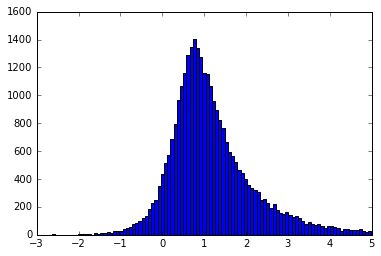

In [9]:
c = 'C1'
plt.hist(data[c][~np.isnan(data[c])].values, bins=100)
plt.show()

Next we only keep a sample of RFQs (that are consistent with the hypotheses in the model) to speed up the estimation procedure.

In [10]:
train_idx = np.random.choice(data.shape[0] - 1, size=5000, replace=False)
d = data.ix[train_idx, :]

In [11]:
# Remove inconsistent RFQs
idx_usable = ~(np.min(d.ix[:, ['C1', 'C2', 'C3', 'C4', 'C5']], axis=1) < d['Y'])
print sum(~idx_usable), d.shape
d = d[idx_usable]

Y_real = d['Y'].values
k_real = d['k'].values
n_real = d['n'].values
C_real = d[['C1', 'C2', 'C3', 'C4', 'C5']].values

def IMap(v):
    if v == 'Done': return 2
    elif v == 'TradedAway': return 1
    elif v == 'NotTraded': return 0
    else:
        print v
        raise ValueError()
I_real = np.array([IMap(v) for v in d['I'].values])

5 (5000, 10)


In [12]:
print sum(d['I'] == 'Done'), sum(d['I'] == 'TradedAway'), sum(d['I'] == 'NotTraded')
print sum(d['I'] == 'Done')  + sum(d['I'] == 'TradedAway') + sum(d['I'] == 'NotTraded')

1282 2540 1173
4995


## Building the model graph

In [13]:
from minipgm.variables import Value, Function
from minipgm.variables import Binomial, Normal, InvGamma, Uniform, Beta

from .variables import BernoulliSEP, BernoulliFlip
from .samplers.sampler_default import KVWSampler

In [14]:
# Priors
mu_0, sigma_0 = Value(0), Value(10)
scale_0, shape_0 = Value(3), Value(3)
a_0, b_0 = Value(1), Value(1)
lower_0, upper_0 = Value(1), Value(3)

# Parameters
mu_V = Normal(mu_0, sigma_0, value=0, name='mu_V')
sigma_V = InvGamma(scale_0, shape_0, value=0.5, name='sigma_V')

mu_W = Normal(mu_0, sigma_0, value=0, name='mu_W')
sigma_W = InvGamma(scale_0, shape_0, value=3, name='sigma_W')
nu_W = Normal(mu_0, sigma_0, value=1, name='nu_W')
tau_W = Uniform(lower_0, upper_0, value=1.5, name='tau_W')

p = Beta(a_0, b_0, value=.5, name='p')

# Variables
m = len(Y_real)
k = np.empty(m, dtype=object)
V = np.empty(m, dtype=object)
W = np.empty(m, dtype=object)
Y = np.empty(m, dtype=object)
I = np.empty(m, dtype=object)
S = np.empty(m, dtype=object)
for i in xrange(m):
    V[i] = Normal(mu_V, sigma_V, name='V_%d' % i)
    if I_real[i] == 2:
        k[i] = Binomial(p, Value(n_real[i]), value=k_real[i], observed=True, name='k_%d' % i)
        W[i] = BernoulliSEP(mu_W, sigma_W, nu_W, tau_W, k[i], value=C_real[i, :k_real[i]], observed=True, name='W_%d' % i)
    else:
        k[i] = Binomial(p, Value(n_real[i]), name='k_%d' % i)
        W[i] = BernoulliSEP(mu_W, sigma_W, nu_W, tau_W, k[i], name='W_%d' % i)
        
    Y[i] = Value(Y_real[i])
    
    @Function
    def S_i(Y=Y[i], V=V[i], W=W[i]):
        
        if len(W) > 0:
            C = np.min(W)
        else:
            C = np.inf
        
        if Y <= np.minimum(C, V): return 2
        if C <= np.minimum(Y, V): return 1
        if V < np.minimum(C, Y): return 0
    
    S[i] = S_i
    I[i] = BernoulliFlip(Value(0.0), S[i], k=3, value=I_real[i], observed=True, name='I_%d' % i)

## Choose variables to sample and assign custom samplers

In [15]:
from qmmc.extended_generic_sampler import VSampler, KVWSampler, _sample_v_single, _decide

In [16]:
# We add all variables to be sampled to the model
all_variables = [mu_V, sigma_V, mu_W, sigma_W, nu_W, tau_W, p]
all_variables.extend(V)
all_variables.extend(W)

In [17]:
# V, k and W have custom samplers used to speed up convergence
v_samplers = [VSampler(V[i]) for i in xrange(m) if W[i]._observed]
kvw_samplers = [KVWSampler(k[i], V[i], W[i], Y[i], I[i]) for i in range(m) if not W[i]._observed]
all_samplers = v_samplers + kvw_samplers

In [18]:
model = Model(variables=all_variables, samplers=all_samplers)

In [ ]:
%%time
model.estimate(5000)

## Results

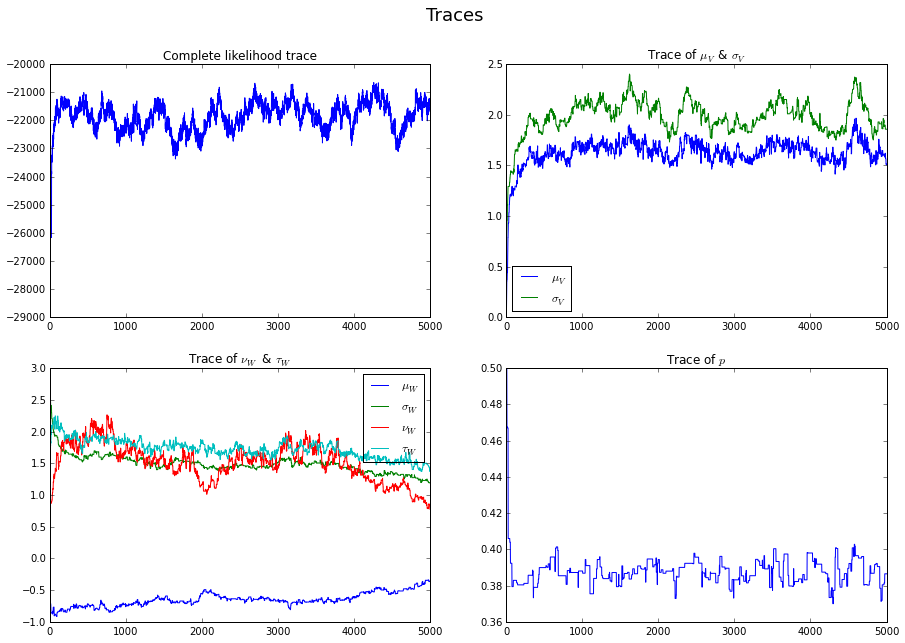

In [20]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(model.logp_hist)
plt.title("Complete likelihood trace")

plt.subplot(2, 2, 2)
mu_V_trace = model.samplers['mu_V'].get_history()
sigma_V_trace = model.samplers['sigma_V'].get_history()
plt.plot(mu_V_trace)
plt.plot(sigma_V_trace)
plt.legend([r"$\mu_V$", r"$\sigma_V$"], loc='best')
plt.title(r"Trace of $\mu_V$ & $\sigma_V$")

plt.subplot(2, 2, 3)
mu_W_trace = model.samplers['mu_W'].get_history()
sigma_W_trace = model.samplers['sigma_W'].get_history()
nu_W_trace = model.samplers['nu_W'].get_history()
tau_W_trace = model.samplers['tau_W'].get_history()
plt.plot(mu_W_trace)
plt.plot(sigma_W_trace)
plt.plot(nu_W_trace)
plt.plot(tau_W_trace)
plt.legend([r"$\mu_W$", r"$\sigma_W$", r"$\nu_W$", r"$\tau_W$"], loc='best')
plt.title(r"Trace of $\nu_W$ & $\tau_W$")

plt.subplot(2, 2, 4)
p_trace = model.samplers['p'].get_history()
plt.plot(p_trace)
plt.title(r"Trace of $p$")

plt.suptitle(r"Traces", size=18)
plt.show()

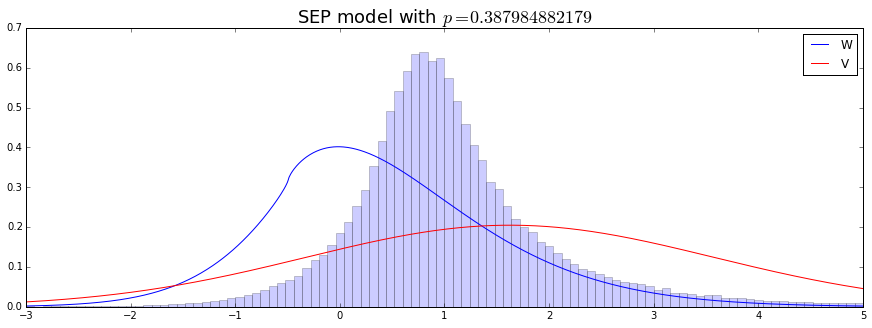

In [21]:
from minipgm.distributions import sep_logpdf

n_burn = 4000
mu_W_avg = np.mean(mu_W_trace[n_burn:])
sigma_W_avg = np.mean(sigma_W_trace[n_burn:])
nu_W_avg = np.mean(nu_W_trace[n_burn:])
tau_W_avg = np.mean(tau_W_trace[n_burn:])

mu_V_avg = np.mean(mu_V_trace[n_burn:])
sigma_V_avg = np.mean(sigma_V_trace[n_burn:])
p_avg = np.mean(p_trace[n_burn:])

plt.figure(figsize=(15, 5))

xx = np.linspace(-3, 5, 1000)

plt.plot(xx, np.exp(sep_logpdf(xx, mu_W_avg, sigma_W_avg, nu_W_avg, tau_W_avg)), color='b')
plt.plot(xx, norm.pdf(xx, mu_V_avg, sigma_V_avg), color='r')
plt.hist(data['Y'].values, bins=100, normed=True, alpha=0.2)

plt.legend(['W', 'V'])
plt.title(r"SEP model with $p = %s$" % p_avg, size=18)
plt.show()

In [22]:
dsave = pd.DataFrame({"mu_V": mu_V_trace, "sigma_V": sigma_V_trace, "mu_W": mu_W_trace, "sigma_W": sigma_W_trace,
                  "nu_W": nu_W_trace, "tau_W": tau_W_trace})

In [23]:
dsave.to_csv("BBG_ratio2.csv")